In [2]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahulchavan99/instagram-reach-forecasting")

print("Path to dataset files:", path)


100%|██████████████████████████████████████| 2.30k/2.30k [00:00<00:00, 1.40MB/s]

Extracting files...
Path to dataset files: /Users/pratham/.cache/kagglehub/datasets/rahulchavan99/instagram-reach-forecasting/versions/1


In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("/Users/pratham/Desktop/IGpostproject/data/Instagram forecast analysis.csv")

In [6]:
df.head()

,Date,Instagram reach
0,2022-04-01T00:00:00,7620
1,2022-04-02T00:00:00,12859
2,2022-04-03T00:00:00,16008
3,2022-04-04T00:00:00,24349
4,2022-04-05T00:00:00,20532


# EDA and FEATURE ENGINEERING

In [8]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             365 non-null    object
 1   Instagram reach  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB
None


In [9]:
print(df.describe())

       Instagram reach
count       365.000000
mean      50474.712329
std       30051.787552
min        7620.000000
25%       25070.000000
50%       43987.000000
75%       68331.000000
max      161998.000000


In [11]:
print(df.isnull().sum())

Date               0
Instagram reach    0
dtype: int64


In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [54]:
# creating new time based features
df['DayOfWeek'] = df['Date'].dt.dayofweek 
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Week'] = df['Date'].dt.isocalendar().week
df['isWeekend'] = df['DayOfWeek'].apply(lambda x:1 if x >=5 else 0)
df['IsStartOfMonth'] = df['Day'].apply(lambda x: 1 if x <= 3 else 0)
df['IsEndOfMonth'] = df['Day'].apply(lambda x: 1 if x >= 28 else 0)
df['Quarter'] = df['Date'].dt.quarter
df['PrevDayReach'] = df['Instagram reach'].shift(1)  # Add lag feature
df = df.dropna()  # Drop first row due to NaN


In [55]:
df.head()

,Date,Instagram reach,DayOfWeek,Month,Day,Week,isWeekend,IsStartOfMonth,IsEndOfMonth,Quarter,PrevDayReach
1,2022-04-02,12859,5,4,2,13,1,1,0,2,7620.0
2,2022-04-03,16008,6,4,3,13,1,1,0,2,12859.0
3,2022-04-04,24349,0,4,4,14,0,0,0,2,16008.0
4,2022-04-05,20532,1,4,5,14,0,0,0,2,24349.0
5,2022-04-06,19408,2,4,6,14,0,0,0,2,20532.0


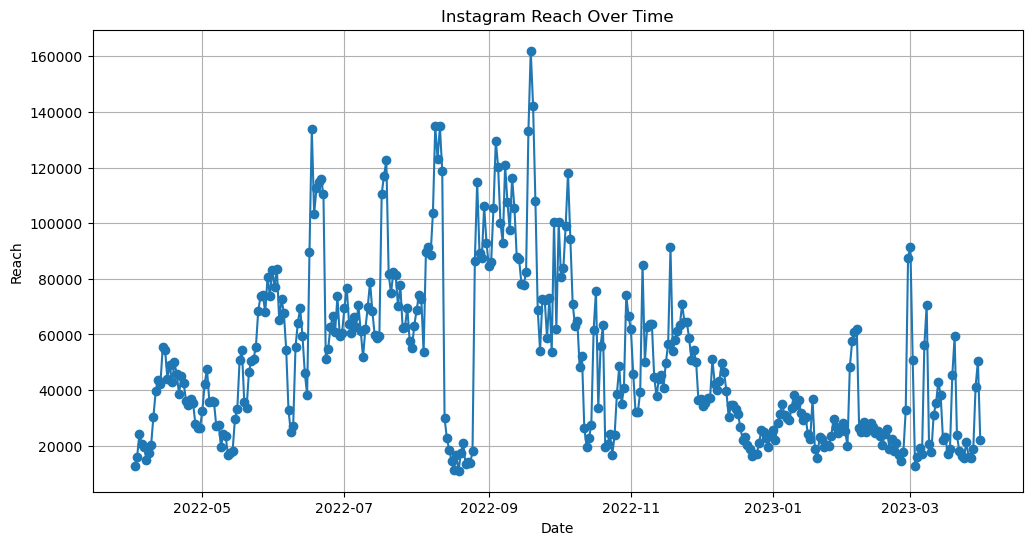

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Instagram reach'], marker='o')
plt.title('Instagram Reach Over Time')
plt.xlabel('Date')
plt.ylabel('Reach')
plt.grid(True)
plt.show()


In [58]:
import seaborn as sns

In [64]:
corr_features = df[['Instagram reach','DayOfWeek', 'Month', 'Day', 'Week', 'isWeekend', 'IsStartOfMonth', 'IsEndOfMonth', 'Quarter', 'PrevDayReach']]
corr_matrix = corr_features.corr()

In [65]:
print(corr_matrix)

                 Instagram reach     DayOfWeek     Month       Day  \
Instagram reach         1.000000 -3.678675e-02  0.306444 -0.070574   
DayOfWeek              -0.036787  1.000000e+00  0.006370 -0.018160   
Month                   0.306444  6.370372e-03  1.000000  0.008564   
Day                    -0.070574 -1.815978e-02  0.008564  1.000000   
Week                    0.290870 -4.287145e-18  0.981289  0.076135   
isWeekend              -0.007344  7.905694e-01  0.001007 -0.011188   
IsStartOfMonth          0.044396  2.795692e-02  0.003636 -0.510466   
IsEndOfMonth            0.033930 -8.689741e-03  0.020524  0.550439   
Quarter                 0.284320  8.600677e-03  0.971434  0.011610   
PrevDayReach            0.857756 -8.005476e-02  0.316637 -0.082403   

                         Week     isWeekend  IsStartOfMonth  IsEndOfMonth  \
Instagram reach  2.908696e-01 -7.344094e-03    4.439629e-02      0.033930   
DayOfWeek       -4.287145e-18  7.905694e-01    2.795692e-02     -0.008690  

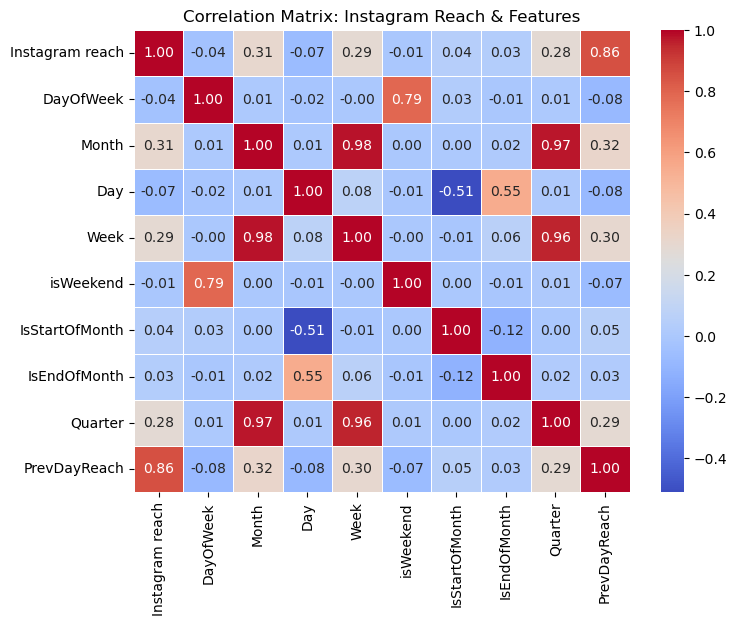

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Instagram Reach & Features")
plt.show()

# Model Building

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [68]:
X = df[['DayOfWeek', 'Month', 'Day', 'Week', 'isWeekend', 'IsStartOfMonth', 'IsEndOfMonth', 'Quarter', 'PrevDayReach']]
y = df['Instagram reach']

In [70]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [71]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [72]:
y_pred = model.predict(X_test)

In [73]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 15719.82
R² Score: 0.67


In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Create a pipeline to scale, then generate polynomial features, then fit model
poly_pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and predict
poly_pipeline.fit(X_train, y_train)
y_pred_poly_scaled = poly_pipeline.predict(X_test)

# Evaluate
rmse_scaled = mean_squared_error(y_test, y_pred_poly_scaled, squared=False)
r2_scaled = r2_score(y_test, y_pred_poly_scaled)

print("📦 Polynomial Regression with Scaling:")
print(f"RMSE: {rmse_scaled:.2f}")
print(f"R² Score: {r2_scaled:.2f}")


📦 Polynomial Regression with Scaling:
RMSE: 17138.21
R² Score: 0.61


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


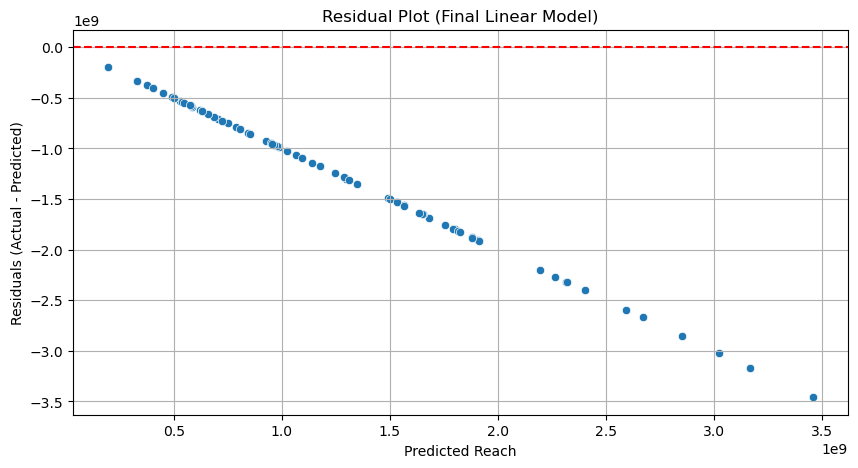

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals from linear regression
y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Final Linear Model)")
plt.xlabel("Predicted Reach")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


In [76]:
# Feature importance from linear regression
coeffs = model.coef_
feature_names = X.columns

print("📊 Feature Importances:")
for name, coef in zip(feature_names, coeffs):
    direction = "↑" if coef > 0 else "↓"
    print(f"{name}: {coef:.2f} ({direction})")


📊 Feature Importances:
DayOfWeek: -844.43 (↓)
Month: 1772.70 (↑)
Day: -380.39 (↓)
Week: -843.31 (↓)
isWeekend: 1938.00 (↑)
IsStartOfMonth: -335.92 (↓)
IsEndOfMonth: 178.73 (↑)
Quarter: 252.10 (↑)
PrevDayReach: 25843.64 (↑)
